In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

#### Data Generation

In [ ]:
n_samples = 2000
n_features = 5

X = np.random.randn(n_samples, n_features) * np.array([1, 10, 100, 0.1, 50])

# Generate imbalanced binary labels
true_w = np.array([0.5, -1.2, 0.03, 2.0, -0.7])
logits = X @ true_w

# Apply sigmoid to get probabilities
probs = 1 / (1 + np.exp(-logits))
y = (probs > 0.8).astype(int)  # imbalanced labels

print("Positive label rate:", y.mean())


Positive label rate: 0.4705


In [30]:
import numpy as np

# Suppose X is a numpy array
print("Shape:", X.shape)

# Mean per feature
print("Mean per feature:", X.mean(axis=0))

# Std per feature
print("Std per feature:", X.std(axis=0))

# Min / Max per feature
print("Min per feature:", X.min(axis=0))
print("Max per feature:", X.max(axis=0))

Shape: (2000, 5)
Mean per feature: [-0.00923219  0.1430176  -0.8523187  -0.00330895  1.29315849]
Std per feature: [1.02103590e+00 1.02329535e+01 1.00703859e+02 9.84685831e-02
 4.89565184e+01]
Min per feature: [-3.92240025e+00 -3.68836529e+01 -3.60108510e+02 -3.00763234e-01
 -1.58835191e+02]
Max per feature: [  3.92623771  35.29055188 315.20567345   0.33773829 192.63657453]


### Problems:
* I immediately notice feature scales differ by orders of magnitude, which can destabilize training.
* The label generation creates strong class imbalance, which may affect optimization and metrics.
* Logits becaome large.
* There may be missing values or NaNs (check .isna().sum()) – can cause NaNs in gradients.

## Suggestions:
* Standardize features ((X - mean)/std) to stabilize training.
* Handle class imbalance via resampling, weighted loss, or focal loss.
* Check distributions quickly with .describe() or .hist().

In [16]:
print("Logits range:", logits_train.min(), logits_train.max())

Logits range: -7358.776836017159 7168.105515150974


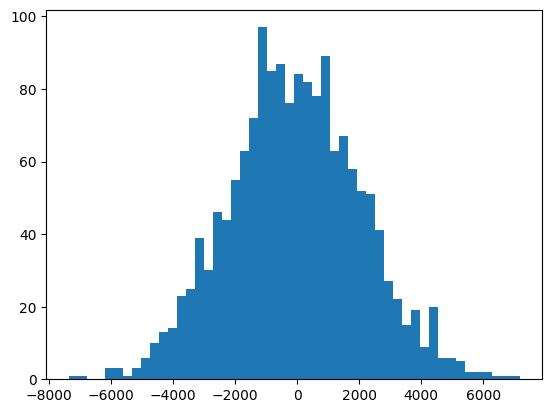

In [17]:
import matplotlib.pyplot as plt
plt.hist(logits_train, bins=50)
plt.show()


I plotted the logits distribution. The range is very wide, indicating features are on different scales. I would standardize features and possibly reduce learning rate to stabilize training.

After standardization, logits should mostly fall in [-5, 5], which avoids numerical overflow in sigmoid and log-loss.

In [18]:
np.bincount(y)

array([1059,  941])

I checked the label distribution. Positive rate is around 47% so class imbalance is moderate. 
It may not be a critical issue here, but in general I would handle imbalance if positive rate is very low or high.

Feature ranges:
[-3.92240025e+00 -3.68836529e+01 -3.60108510e+02 -3.00763234e-01
 -1.58835191e+02]
[  3.92623771  35.29055188 315.20567345   0.33773829 192.63657453]

Positive label rate: 0.4705


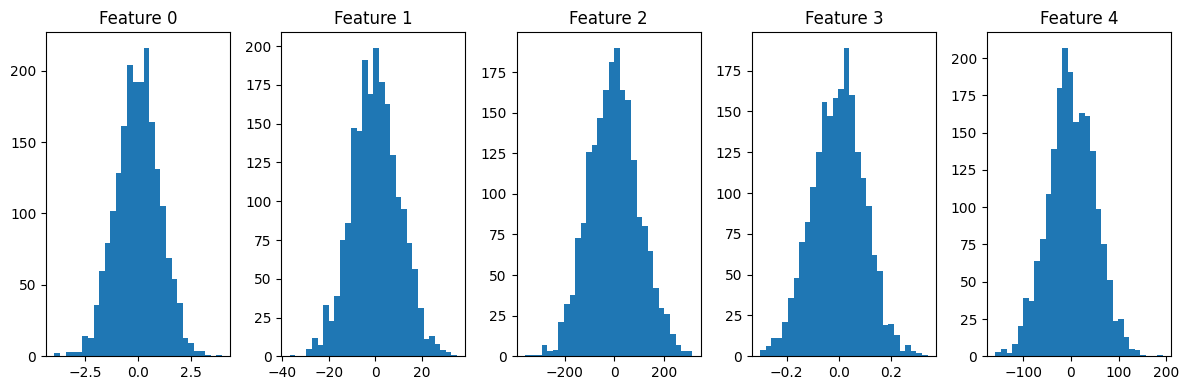

In [ ]:
# =============================
# Inspect features, labels, and logits
# =============================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Print basic info
print("Feature ranges:")
print(np.min(X, axis=0))
print(np.max(X, axis=0))
print("\nPositive label rate:", y.mean())

# Plot feature distributions
plt.figure(figsize=(12, 4))
for i in range(X.shape[1]):
    plt.subplot(1, X.shape[1], i+1)
    plt.hist(X[:, i], bins=30)
    plt.title(f'Feature {i}')
plt.tight_layout()
plt.show()


In [24]:
# =============================
# Fix: Standardize features
# =============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_val_scaled = scaler.transform(X_val)

# Check standardized feature ranges
print("After scaling:")
print(np.min(X_scaled, axis=0))
print(np.max(X_scaled, axis=0))

# Compute logits after scaling (still zero-initialized weights)
logits_scaled = X_scaled @ np.zeros(X.shape[1])

# =============================
# Summary for interview
# =============================
# "Features are standardized, so logits should remain in a reasonable range [-5,5] during training,
# avoiding overflow in sigmoid and stabilizing loss computation."

After scaling:
[-3.83254699 -3.61837573 -3.56745209 -3.02080397 -3.27082796]
[3.85438935 3.43473997 3.13848939 3.46351322 3.90843594]


#### Train Test split

In [10]:
split = int(0.8 * n_samples)

X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]
print("Training set positive label rate:", y_train.mean())
print("Validation set positive label rate:", y_val.mean())  

Training set positive label rate: 0.469375
Validation set positive label rate: 0.475


#### Problem: 
I noticed the data was split by simple slicing, which could introduce bias if the labels are ordered. 
#### Suggestion:
I would use train_test_split with shuffling to ensure the training and validation sets are representative and that metrics reflect the true performance.

In [25]:
# Fix suggestion
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("Training set positive label rate:", y_train.mean())
print("Validation set positive label rate:", y_val.mean())


Training set positive label rate: 0.4775
Validation set positive label rate: 0.4425


#### Model Utils

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def compute_loss(logits, y):
    return np.mean(logits)  


In [26]:
# Fix - Loss correction:

def binary_cross_entropy_loss(logits, labels):
    probs = sigmoid(logits)
    loss = -np.mean(labels * np.log(probs) + (1 - labels) * np.log(1 - probs))
    return loss

#### Training Loop

In [ ]:
# Wrong loss function used previously
lr = 1.0
n_epochs = 50

w = np.zeros(n_features)

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    logits_train = X_train @ w
    probs_train = sigmoid(logits_train)

    grad = X_train.T @ (probs_train - y_train) / len(y_train)
    w -= lr * grad

    train_loss = compute_loss(logits_train, y_train)
    val_loss = compute_loss(X_val @ w, y_val)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")


Epoch 0: train_loss=0.0000, val_loss=-25.0914
Epoch 10: train_loss=-40.9204, val_loss=-65.9072
Epoch 20: train_loss=-37.4772, val_loss=-71.2562
Epoch 30: train_loss=-37.9842, val_loss=-81.0124
Epoch 40: train_loss=-38.9917, val_loss=-90.1052


/var/folders/6l/zgnfrkfn63qcyllsbv5jpy800000gn/T/ipykernel_87744/1282094684.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


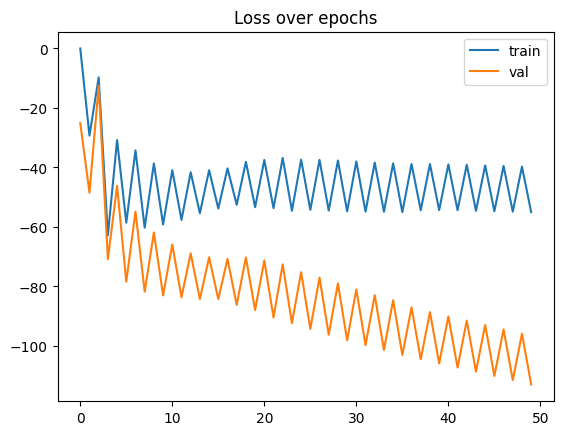

In [13]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.title("Loss over epochs")
plt.show()


#### Problems / Observations:

* Learning rate too high – if loss is diverging or oscillating, the step size might be too large.
* Features not standardized – different scales can destabilize gradient updates.
* Loss bug – e.g., using mean(logits) instead of proper log-loss / binary cross-entropy.
* No shuffle between epochs – can cause patterns in batches, slowing convergence.
* Label imbalance not handled – can bias the model toward majority class (though mild in this dataset).
* Validation loss behavior – if validation loss keeps decreasing/increasing abnormally, indicates a training or loss issue, not model capacity.
* Overflow in sigmoid/log calculations – extremely large logits cause numerical instability.

#### Suggested Fixes / Actions:

* Standardize features (e.g., StandardScaler).
* Reduce learning rate, optionally add early stopping.
* Correct loss calculation to proper log-loss (binary cross-entropy).
* Shuffle training data every epoch.
* Optionally, handle label imbalance with class weights or resampling.
* Monitor train/validation loss and metrics to ensure stable learning.

Epoch 0: train_loss=0.6931, val_loss=0.6916
Epoch 5: train_loss=0.6854, val_loss=0.6842
Epoch 10: train_loss=0.6778, val_loss=0.6769
Epoch 15: train_loss=0.6705, val_loss=0.6697
Epoch 20: train_loss=0.6633, val_loss=0.6628
Epoch 25: train_loss=0.6562, val_loss=0.6560
Epoch 30: train_loss=0.6494, val_loss=0.6493
Epoch 35: train_loss=0.6427, val_loss=0.6429
Epoch 40: train_loss=0.6362, val_loss=0.6365
Epoch 45: train_loss=0.6298, val_loss=0.6303


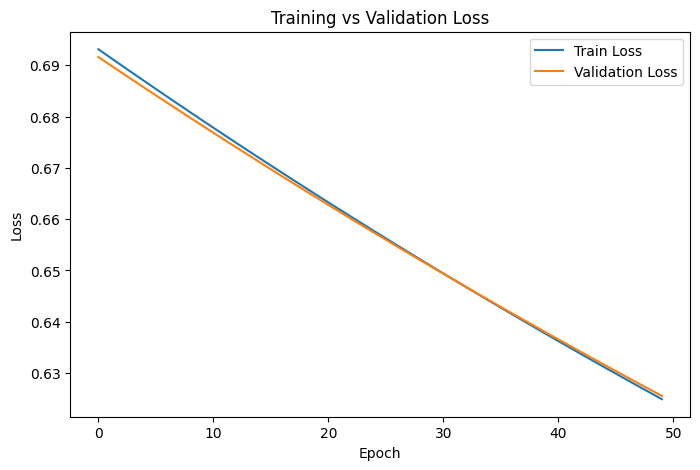

In [27]:
# Fix suggestion

# =============================
# Final Training Loop with fixes
# =============================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Assume X_train, X_val, y_train, y_val are defined from previous split

# 1. Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 2. Initialize weights
n_features = X_train_scaled.shape[1]
w = np.zeros(n_features)

# 3. Hyperparameters
lr = 0.01  # lower learning rate to stabilize training
n_epochs = 50

train_losses = []
val_losses = []

# 4. Training loop with shuffle
for epoch in range(n_epochs):
    # Shuffle training data each epoch
    X_train_epoch, y_train_epoch = shuffle(X_train_scaled, y_train, random_state=epoch)
    
    # Compute logits and probabilities
    logits_train = X_train_epoch @ w
    probs_train = 1 / (1 + np.exp(-logits_train))  # sigmoid
    
    # Gradient
    grad = X_train_epoch.T @ (probs_train - y_train_epoch) / len(y_train_epoch)
    w -= lr * grad
    
    # Compute loss with correct binary cross-entropy
    def compute_loss(logits, y_true):
        eps = 1e-8  # avoid log(0)
        probs = 1 / (1 + np.exp(-logits))
        return -np.mean(y_true * np.log(probs + eps) + (1 - y_true) * np.log(1 - probs + eps))
    
    train_loss = compute_loss(logits_train, y_train_epoch)
    val_loss = compute_loss(X_val_scaled @ w, y_val)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

# 5. Plot training and validation loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


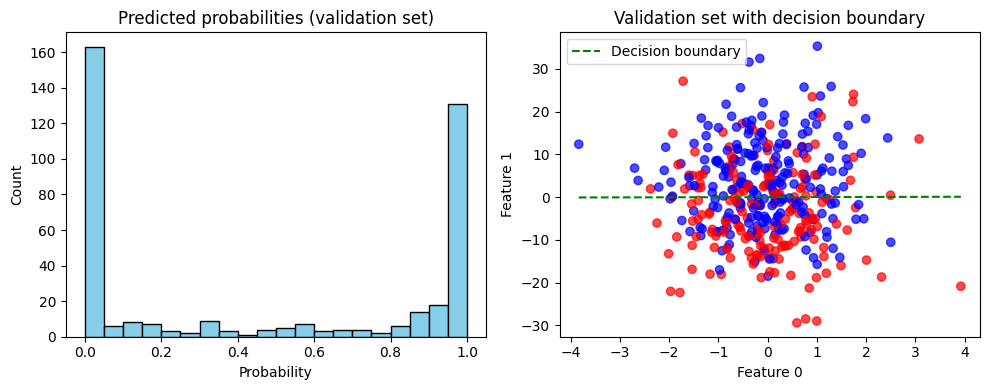

In [28]:
# Plot predicted probabilities and decision boundary
import matplotlib.pyplot as plt

# Compute probabilities on validation set
probs_val = sigmoid(X_val @ w)

plt.figure(figsize=(10, 4))

# 1. Histogram of predicted probabilities
plt.subplot(1, 2, 1)
plt.hist(probs_val, bins=20, color='skyblue', edgecolor='black')
plt.title("Predicted probabilities (validation set)")
plt.xlabel("Probability")
plt.ylabel("Count")

# 2. Scatter plot with decision boundary
plt.subplot(1, 2, 2)
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='bwr', alpha=0.7)
# decision boundary for logistic regression: w0*x0 + w1*x1 = 0
x_vals = np.linspace(X_val[:, 0].min(), X_val[:, 0].max(), 100)
if w[1] != 0:
    y_vals = -(w[0] * x_vals) / w[1]
    plt.plot(x_vals, y_vals, color='green', linestyle='--', label='Decision boundary')
plt.title("Validation set with decision boundary")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend()

plt.tight_layout()
plt.show()
